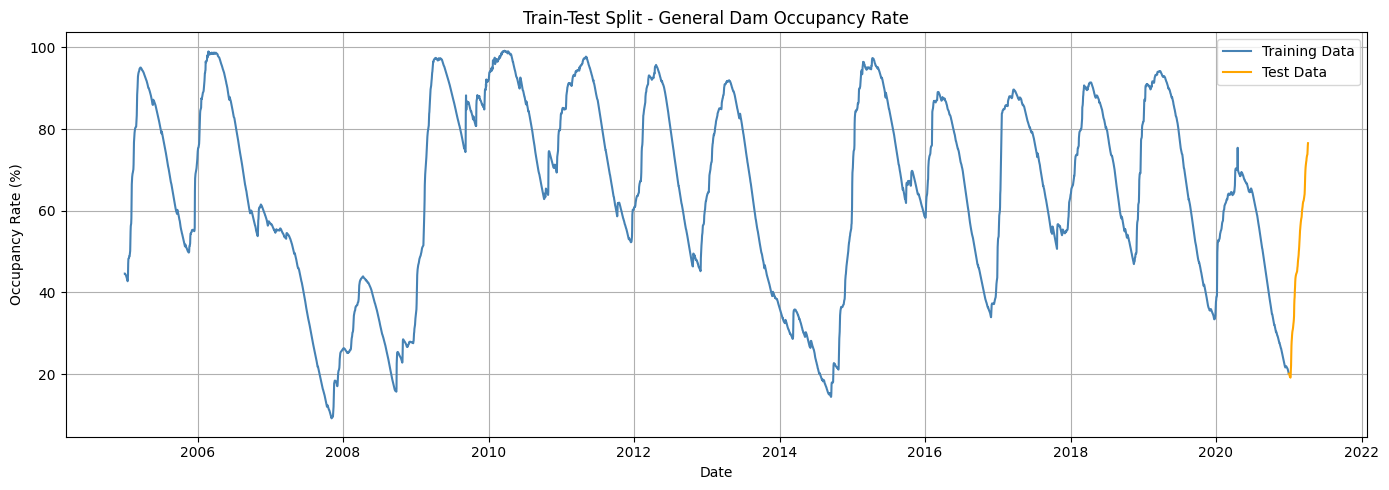

01:12:52 - cmdstanpy - INFO - Chain [1] start processing
01:12:55 - cmdstanpy - INFO - Chain [1] done processing


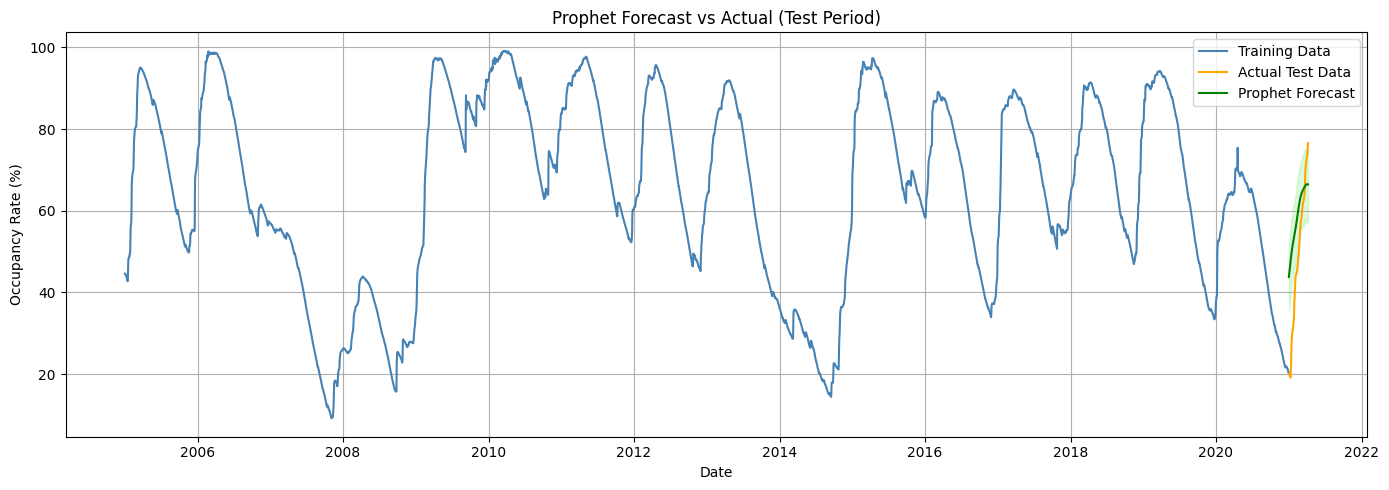

Prophet MAE (Test Set): 12.30
Prophet RMSE (Test Set): 14.62


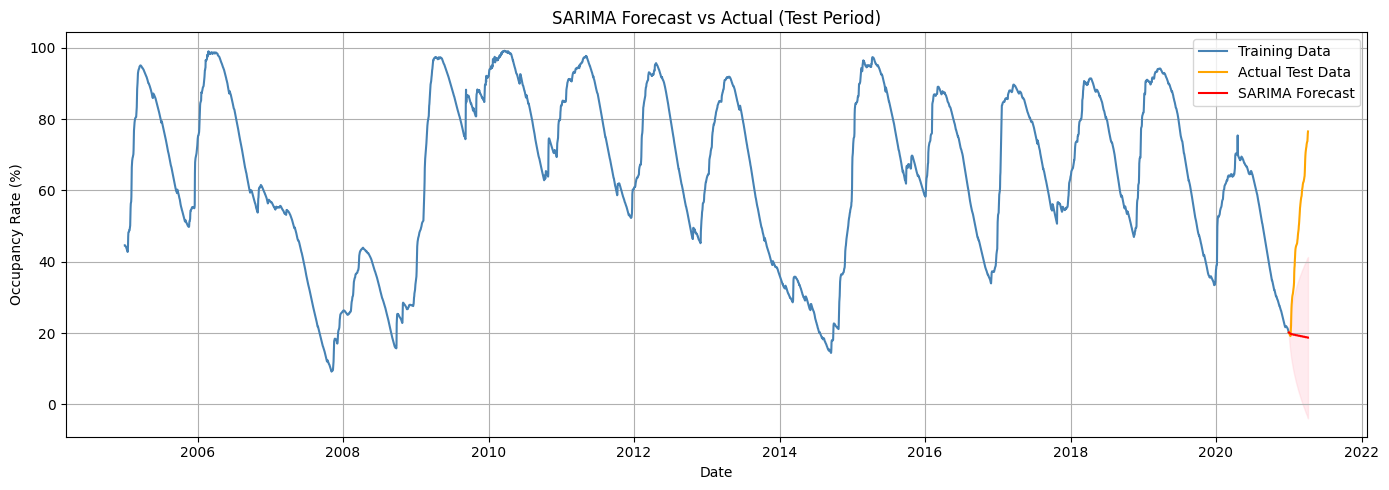

SARIMA MAE (Test Set): 29.09
SARIMA RMSE (Test Set): 33.86


In [1]:
# Importing necessary libraries for time series forecasting and performance evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppressing warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

# Loading the preprocessed general dam occupancy dataset
df = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")

# Converting DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')

# Defining train-test split point
split_date = '2021-01-01'
df_train = df[df['DATE'] < split_date]
df_test = df[df['DATE'] >= split_date]

# Plotting the train and test split
plt.figure(figsize=(14,5))
plt.plot(df_train['DATE'], df_train['GENERAL_DAM_OCCUPANCY_RATE'], label='Training Data', color='steelblue')
plt.plot(df_test['DATE'], df_test['GENERAL_DAM_OCCUPANCY_RATE'], label='Test Data', color='orange')
plt.title('Train-Test Split - General Dam Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Occupancy Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Preparing the data for Prophet model by renaming columns as required
df_prophet_train = df_train.rename(columns={
    'DATE': 'ds',
    'GENERAL_DAM_OCCUPANCY_RATE': 'y'
})

# Initializing and fitting the Prophet model on the training data
model_prophet = Prophet()
model_prophet.fit(df_prophet_train)

# Creating a dataframe for the test period forecast
future = df_test[['DATE']].rename(columns={'DATE': 'ds'})

# Generating predictions for the test period
forecast = model_prophet.predict(future)

# Plotting the Prophet forecast compared to actual test data
plt.figure(figsize=(14,5))
plt.plot(df_train['DATE'], df_train['GENERAL_DAM_OCCUPANCY_RATE'], label='Training Data', color='steelblue')
plt.plot(df_test['DATE'], df_test['GENERAL_DAM_OCCUPANCY_RATE'], label='Actual Test Data', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgreen', alpha=0.3)
plt.title("Prophet Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculating Prophet model performance on the test set
mae_prophet = mean_absolute_error(df_test['GENERAL_DAM_OCCUPANCY_RATE'], forecast['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(df_test['GENERAL_DAM_OCCUPANCY_RATE'], forecast['yhat']))

print(f"Prophet MAE (Test Set): {mae_prophet:.2f}")
print(f"Prophet RMSE (Test Set): {rmse_prophet:.2f}")

# Preparing the data for SARIMA model by setting the date as the index
df_train_sarima = df_train.set_index('DATE')
df_train_sarima.index = pd.DatetimeIndex(df_train_sarima.index).to_period('D')

# Fitting the SARIMA model on the training data
sarima_model = sm.tsa.statespace.SARIMAX(
    df_train_sarima['GENERAL_DAM_OCCUPANCY_RATE'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)
sarima_result = sarima_model.fit()

# Generating forecast for the test period using SARIMA
forecast_sarima = sarima_result.get_forecast(steps=len(df_test))
sarima_pred = forecast_sarima.predicted_mean
sarima_ci = forecast_sarima.conf_int()

# Plotting the SARIMA forecast compared to actual test data
plt.figure(figsize=(14,5))
plt.plot(df_train['DATE'], df_train['GENERAL_DAM_OCCUPANCY_RATE'], label='Training Data', color='steelblue')
plt.plot(df_test['DATE'], df_test['GENERAL_DAM_OCCUPANCY_RATE'], label='Actual Test Data', color='orange')
plt.plot(df_test['DATE'], sarima_pred, label='SARIMA Forecast', color='red')
plt.fill_between(df_test['DATE'],
                 sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculating SARIMA model performance on the test set
mae_sarima = mean_absolute_error(df_test['GENERAL_DAM_OCCUPANCY_RATE'], sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(df_test['GENERAL_DAM_OCCUPANCY_RATE'], sarima_pred))

print(f"SARIMA MAE (Test Set): {mae_sarima:.2f}")
print(f"SARIMA RMSE (Test Set): {rmse_sarima:.2f}")
